In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV 
from sklearn.ensemble import RandomForestRegressor
plt.figure(figsize=(15,15))
%matplotlib inline
# ROOT = r'/kaggle/input/ames-housing-dataset/AmesHousing.csv'
# ROOT = r'/Users/harikesh/Desktop/ClassicalMachineLearning-ISL/AmesHousePrediction/AmesHousing.csv'
ROOT = r'/Users/harikesh/Desktop/ClassicalMachineLearning-ISL/Datasets/house-prices-advanced-regression-techniques/train.csv'

In [221]:
df = pd.read_csv(ROOT)
instances,features = df.shape
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1]:
plt.figure(figsize=(30,12))
sns.barplot(df.isnull().sum()[df.isnull().sum()> 0])

NameError: name 'plt' is not defined

### Null Values
-----------
**LotFrontage** : Linear feet of street connected *Numerical, Continous* <br>
**Alley** : type of alley access to property, *categorical* <br>
**MasVnrType** : masonry venner (whatever the hell it is) type, *categorical and maybe ordinal as well* (least values missing, easily filled with mode)<br>
**BsmtCond** : *ordinal* evaluation of the quality of the height of the basement <br>
**BsmtExposure** : walkout or garden level walls *ordinal* <br>
**BsmtFnType1** : rating of basement finished area
**BsmtFnType2** : similar to above but for multiple types <br>
**Electrical** : electrical system type *categorical* <br>
**FireplaceQu** : fireplace quality *ordinal* <br>
**GarageType** : garage location maybe *ordinal* or *categorical* <br>
**GarageYrBlt** : year the garage was built <br>
**GarageFinish** : interior finish of the garage *ordinal* <br>
**GarageQual** : quality of the garage *ordinal* <br>
**GarageCond** : condition of garage *ordinal* <br>
**PoolQC** : quality of pool *ordinal* <br>
**Fence** : fence quality *ordinal* <br>
**MiscFeature** : some miscellaneous features, notcovered in the original 80 features like elevator, 2nd garage, other, sheds tennis court <br>

- values with less than *10% of df.shape[0]* can be simply imputed with mean (for numerical) and mode (for categorical)
- other values can also be imputed like that but categorical values maybe needed to be droped entirely 

In [223]:
simply_imputed = df.isnull().sum()[(df.isnull().sum() <= 0.1*instances) & (df.isnull().sum() > 0)]
not_simply_imputed = df.isnull().sum()[(df.isnull().sum() > 0.1*instances) & (df.isnull().sum()>0)]

In [237]:
for feat in simply_imputed.index.tolist():
    print(f'{feat}, {str(df[feat].dtype)}')

MasVnrArea, float64
BsmtQual, object
BsmtCond, object
BsmtExposure, object
BsmtFinType1, object
BsmtFinType2, object
Electrical, object
GarageType, object
GarageYrBlt, float64
GarageFinish, object
GarageQual, object
GarageCond, object


### not simple imputing features

- NA in PoolQc means no pool, so instead of using null, I should give it 0 or something 
- similarly in Alley,MiscFeature, Fence, MasVnrType,FireplaceQu
- LotFrontage is numerical continous, see if it depends on anything or simple imputer

### simple imputing features
- even here the pattern is consistent 
- object dtype features with null values actually don't posses that feature
- so BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2, Garage{anything other than Blt}
- Garage blt is numerical
- Electrical needs mode based imputation

In [225]:
imputing_simple = pd.DataFrame({
    'features':simply_imputed.index.tolist(),
    'type':['num','cat','cat','cat','cat','cat','cat','cat','num','cat','cat','cat']
})

In [226]:
imputing_not_simple = pd.DataFrame({
    'Features':not_simply_imputed.index.tolist(),
    'Type':['num','cat','cat','cat','cat','cat','cat']
})

# Simple Imputation

In [227]:
# #simply imputing the simple_imputed features
for idx,feat in enumerate(imputing_simple.features):
    if imputing_simple.iloc[idx,1] == 'cat':
        if str(feat)!= 'Electrical':
            df[feat].fillna("no",inplace=True)
        else:
            df['Electrical'].fillna(df['Electrical'].mode().iloc[0],inplace=True)
    else:
        df[feat].fillna(df[feat].median() if str(feat).endswith('YrBlt') else df[feat].mean(),inplace=True)

/var/folders/f6/nmq5h9nx4pg4d5qvp725r4900000gn/T/ipykernel_37272/2975470378.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feat].fillna(df[feat].median() if str(feat).endswith('YrBlt') else df[feat].mean(),inplace=True)
/var/folders/f6/nmq5h9nx4pg4d5qvp725r4900000gn/T/ipykernel_37272/2975470378.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

In [228]:
df.isnull().sum()[df.isnull().sum() > 0]

LotFrontage     259
Alley          1369
MasVnrType      872
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

# Not So Simple Imputation

In [229]:
matrix = df.corr(numeric_only=True)['LotFrontage']
# sns.heatmap(,cmap='viridis')

In [230]:
matrix[(matrix.values < 0)].sort_values(ascending=False)*100

KitchenAbvGr    -0.606883
BsmtHalfBath    -0.723430
Id              -1.060069
OverallCond     -5.921345
MSSubClass     -38.634689
Name: LotFrontage, dtype: float64

In [231]:
top_k_features = ['1stFlrSF','LotArea','GrLivArea','TotalBsmtSF','TotRmsAbvGrd','MSSubClass']
df['LotFrontage'] = df.groupby(top_k_features)['LotFrontage'].fillna(df['LotFrontage'].mean())

/var/folders/f6/nmq5h9nx4pg4d5qvp725r4900000gn/T/ipykernel_37272/3731089801.py:2: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['LotFrontage'] = df.groupby(top_k_features)['LotFrontage'].fillna(df['LotFrontage'].mean())


In [232]:
for idx, features in enumerate(imputing_not_simple.Features):
    if imputing_not_simple.iloc[idx,1] == 'cat':
        df.fillna({features:"no"},inplace=True)
        print(df[features])

0       no
1       no
2       no
3       no
4       no
        ..
1455    no
1456    no
1457    no
1458    no
1459    no
Name: Alley, Length: 1460, dtype: object
0       BrkFace
1            no
2       BrkFace
3            no
4       BrkFace
         ...   
1455         no
1456      Stone
1457         no
1458         no
1459         no
Name: MasVnrType, Length: 1460, dtype: object
0       no
1       TA
2       TA
3       Gd
4       TA
        ..
1455    TA
1456    TA
1457    Gd
1458    no
1459    no
Name: FireplaceQu, Length: 1460, dtype: object
0       no
1       no
2       no
3       no
4       no
        ..
1455    no
1456    no
1457    no
1458    no
1459    no
Name: PoolQC, Length: 1460, dtype: object
0          no
1          no
2          no
3          no
4          no
        ...  
1455       no
1456    MnPrv
1457    GdPrv
1458       no
1459       no
Name: Fence, Length: 1460, dtype: object
0         no
1         no
2         no
3         no
4         no
        ... 
1455      no

In [233]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

# Imputted all the null values 

In [234]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,no,Reg,Lvl,AllPub,...,0,no,no,no,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,no,Reg,Lvl,AllPub,...,0,no,no,no,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,no,IR1,Lvl,AllPub,...,0,no,no,no,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,no,IR1,Lvl,AllPub,...,0,no,no,no,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,no,IR1,Lvl,AllPub,...,0,no,no,no,0,12,2008,WD,Normal,250000


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Preprocessing

## Proposed Transformations
- [x] log transform the SalePrice columns(right skewed by the histogram)
- [ ] MSSubClass will get categorical encoding based on the top 10 most frequent classes and others will be binned
- [ ] MSZoning will get ordinal, based on the data found on internet 
- [ ] LotFrontage, LotArea will get transformations based on the distribution and maybe new features will havet to be made out of them
- [ ] Street gets ordinal Pave > Grvl
- [ ] Alley as well ordinal
- [ ] Lot Shape gets ordinal too Reg > IR1 > IR2 > IR3
- [ ] LandCountour another ordinal based on the data (groupby this feature and check the average price of property)
- [ ] Utilites also Ordinal 
- [ ] LotConfig, search about is but most probably ordinal 
- [ ] LandSlope is ordinal as well
- [ ] Neighborhood is categorical with binning top 5 or top 10
- [ ] Condition1, Condition2 as well, might not need binning based on the frequency
- [ ] HouseStyle gets ordinal for sure
- [ ] OverallQual is ordinal already, 
    - [ ] maybe mix this with Overall Cont with multiplication and normalization (trees don't care about it, so fish it !)
- [ ] Year built needs nothing but study it using hist or graphs maybe 
- [ ] RoofStyle get's one hot categorical
- [ ] RoofMatl gets ordinal
- [ ] exteriors get categorical and ordinal 
- [ ] MasVnr get's ordinal
- [ ] MasVnrArea may need transformation, based on histogram
- [ ] ExterQual, ExterCond gets ordinal and feature combining as well
- [ ] foundation get's ordinal
- [ ] BsmtQual, BsmtCond, BsmtExposure maybe combined 
- [ ] BsmtFinType1 and 2 get combined
- [ ] BsmtFinSF1 and 2 get transformations if needed 
    - [ ] TotalBsmtSF and BsmtUnfSF have to be merged somehow with SF1 and SF2
- [ ] ordinal scores based on Heating and HeatingQC and central air 
- [ ]Electrical systems oridnal I guess

In [357]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder

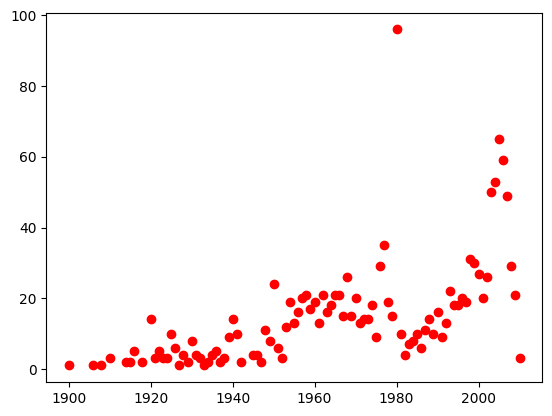

In [332]:
plt.plot(df.GarageYrBlt.value_counts(),'ro')

In [342]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['SinceRemodel'] = df['YrSold'] - df['YearRemodAdd']

df['LivingAreaRatio'] = df['GrLivArea'] / (df['TotalSF'] + 1)
df['BasementRatio'] = df['TotalBsmtSF'] / (df['GrLivArea'] + 1)
df['GarageRatio'] = df['GarageArea'] / (df['GrLivArea'] + 1)

df['YearBin'] = pd.cut(df['YearBuilt'], bins=[1870, 1945, 1970, 1995, 2010], labels=False)
df['GarageYearBin'] = pd.cut(df['GarageYrBlt'], bins=[1900,1930,1960,1990,2020], labels=False)


In [371]:
xtrain,xtest,ytrain,ytest = train_test_split(df.drop(columns=['Id','SalePrice','YearBuilt','GarageYrBlt']),df['SalePrice'],test_size=0.1,random_state=1337)

In [345]:
# xtrain[]
xtrain.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,TotalSF,TotalBath,HouseAge,SinceRemodel,LivingAreaRatio,BasementRatio,GarageRatio,YearBin,GarageYearBin
191,60,RL,70.049958,7472,Pave,no,IR1,Lvl,AllPub,CulDSac,...,Normal,2204,2.5,35,3,0.670748,0.489865,0.327027,2,2.0
434,180,RM,21.000000,1890,Pave,no,Reg,Lvl,AllPub,Inside,...,Normal,1260,2.0,36,36,0.499603,0.998415,0.000000,2,2.0
335,190,RL,70.049958,164660,Grvl,no,IR1,HLS,AllPub,Corner,...,Normal,3285,4.0,43,43,0.543518,0.838836,0.296027,1,2.0
241,30,RM,40.000000,3880,Pave,no,Reg,Lvl,AllPub,Inside,...,Normal,1552,1.0,62,10,0.557630,0.791234,0.000000,0,2.0
1409,60,RL,46.000000,20544,Pave,no,IR1,Lvl,AllPub,CulDSac,...,Normal,2884,2.5,22,17,0.725477,0.377746,0.258835,2,2.0


In [372]:
numerical_features = xtrain.select_dtypes(include='number').columns.tolist()
# numerical_features?
non_numerical_features = xtrain.select_dtypes(exclude='number').columns.tolist()

In [355]:
len(non_numerical_features)

43

'\nlog transform in LotFrontage, LotArea GrLivArea 1stFlrSF \nYearBuilt, GarageYrBlt me do binning \n\n'

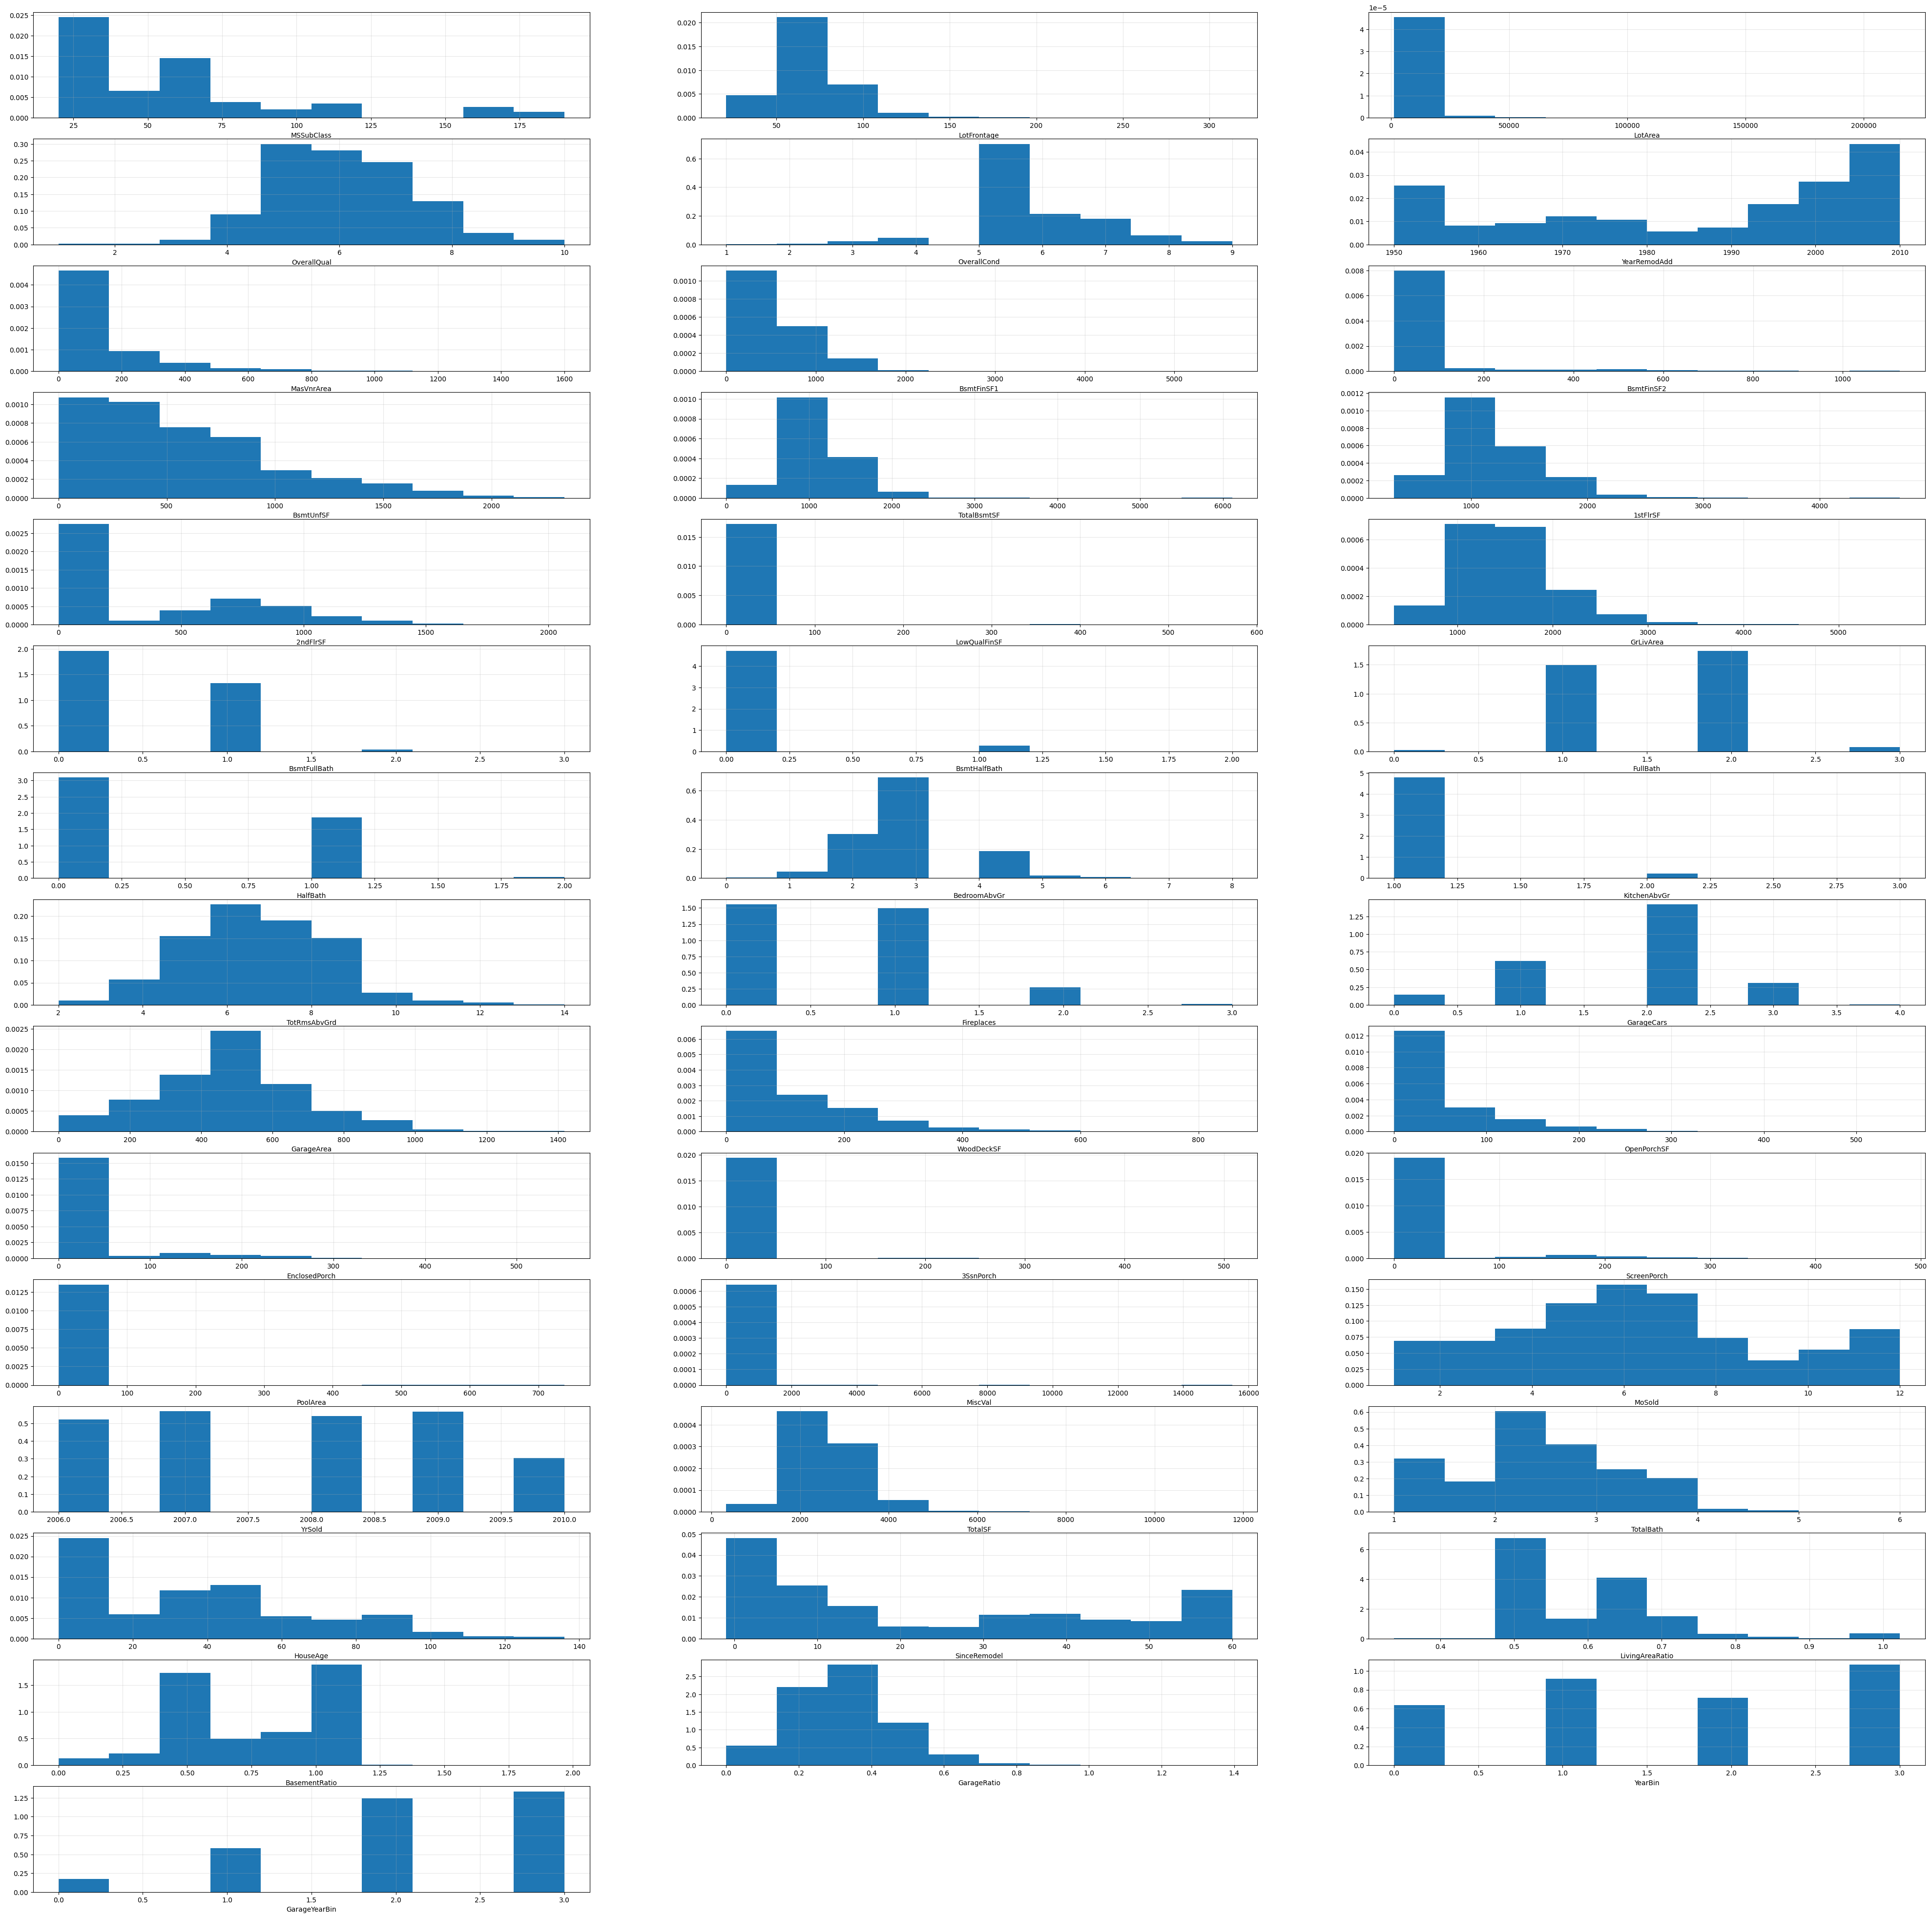

In [373]:
plt.figure(figsize=(50,50))
for idx,feats in enumerate(numerical_features):
    plt.subplot(15,3,idx+1)
    plt.hist(xtrain[feats],density=True)
    plt.xlabel(feats)
    plt.grid(alpha=0.3)
# plt.tight_layout()

'''
log transform in LotFrontage, LotArea GrLivArea 1stFlrSF 
YearBuilt, GarageYrBlt me do binning 

'''

In [374]:
logtf = FunctionTransformer(np.log)

num_tf = ColumnTransformer(transformers=[
    ('LotFrontage',logtf,['LotFrontage']),
    ('LotArea',logtf,['LotArea']),
    ('GrLivArea',logtf,['GrLivArea']),
    ('1stFlrSF',logtf,['1stFlrSF'])
],remainder='passthrough')

num_tf.fit_transform(xtrain).shape

(1314, 86)

In [356]:
non_numerical_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [375]:
def clamp_bin_features(series,threshold=0.05):
    freq = series.value_counts(normalize=True)
    rare_categories = freq[freq < threshold].index
    return series.apply(lambda x: 'Rare' if x in rare_categories else x)

In [376]:
for features in ['Neighborhood','RoofStyle','Exterior1st','Exterior2nd']:
    xtrain[features] = clamp_bin_features(df[features])

In [378]:
df.BsmtQual.value_counts()

BsmtQual
TA    649
Gd    618
Ex    121
no     37
Fa     35
Name: count, dtype: int64